In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pos_df = pd.read_csv('WRKY_info_20190507/WRKY_info_table_positive.csv', sep='\t')
neg1_df = pd.read_csv('WRKY_info_20190507/WRKY_info_table_negative_one.csv', sep='\t')
neg2_df = pd.read_csv('WRKY_info_20190507/WRKY_info_table_negative_two.csv', sep='\t')
neg3_df = pd.read_csv('WRKY_info_20190507/WRKY_info_table_negative_three.csv', sep='\t')

In [3]:
print(pos_df.info())
pos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26480 entries, 0 to 26479
Data columns (total 5 columns):
TF_ID        26480 non-null object
Pseq_ID      26480 non-null object
Pseq         26480 non-null object
DBD_seq      26480 non-null object
matrix_ID    26480 non-null object
dtypes: object(5)
memory usage: 1.0+ MB
None


,TF_ID,Pseq_ID,Pseq,DBD_seq,matrix_ID
0,AT1G13960,TFprotseq_12499,MSEKEEAPSTSKSTGAPSRPTLSLPPRPFSEMFFNGGVGFSPGPMT...,ADDGYNWRKYGQKQVKGSEFPRSYYKCTNPGCPVKKKVERSLDGQV...,TF_motif_seq_0270
1,AT1G13960,TFprotseq_12499,MSEKEEAPSTSKSTGAPSRPTLSLPPRPFSEMFFNGGVGFSPGPMT...,ADDGYNWRKYGQKQVKGSEFPRSYYKCTNPGCPVKKKVERSLDGQV...,TF_motif_seq_0339
2,AT1G13960,TFprotseq_12499,MSEKEEAPSTSKSTGAPSRPTLSLPPRPFSEMFFNGGVGFSPGPMT...,ADDGYNWRKYGQKQVKGSEFPRSYYKCTNPGCPVKKKVERSLDGQV...,TFmatrixID_0449
3,AT1G13960,TFprotseq_12499,MSEKEEAPSTSKSTGAPSRPTLSLPPRPFSEMFFNGGVGFSPGPMT...,ADDGYNWRKYGQKQVKGSEFPRSYYKCTNPGCPVKKKVERSLDGQV...,TFmatrixID_0451
4,AT1G13960,TFprotseq_12499,MSEKEEAPSTSKSTGAPSRPTLSLPPRPFSEMFFNGGVGFSPGPMT...,ADDGYNWRKYGQKQVKGSEFPRSYYKCTNPGCPVKKKVERSLDGQV...,TFmatrixID_0465


In [4]:
ATCG_1D_list = ['A', 'C', 'G', 'T']
ATCG_2D_list = []
ATCG_3D_list = []

for i in range(4):
    for j in range(4):
        ATCG_2D_list.append(ATCG_1D_list[i] + ATCG_1D_list[j])
        for k in range(4):
            ATCG_3D_list.append(ATCG_1D_list[i] + ATCG_1D_list[j] + ATCG_1D_list[k])

In [5]:
col_names = ['matrix_ID', 'alength', 'width', 'nsites', 'E', 'ATCG_prob_list', 'DNA_seq'] + ATCG_2D_list + ATCG_3D_list
matrices_df = pd.DataFrame(columns=col_names)

In [6]:
matricesFile = open('WRKY_info_20190507/All_matrices.txt', 'r')
for i in range(8):
    matricesFile.readline()

In [7]:
# decode index to ATCG character
def getATCGchar(index):
    if (index == -1):
        return '_'
    elif (index == 0):
        return 'A'
    elif (index == 1):
        return 'C'
    elif (index == 2):
        return 'G'
    elif (index == 3):
        return 'T'

In [8]:
while True:
    # eat empty line
    matricesFile.readline()
    
    # Read matrix header
    header = matricesFile.readline().rstrip('\n')
    
    # If the header have nothing, it means we are at the EOF, then break and stop reading it
    if len(header) == 0:
        break
    header = header.split()[1]
    
    # eat empty line
    matricesFile.readline()
    
    # read matrix basic info(alength, width, nsites, E)
    matrix_info = matricesFile.readline()
    matrix_info = matrix_info.split()
    
    alength = int(matrix_info[3])
    width = int(matrix_info[5])
    nsites = int(matrix_info[7])
    E = int(matrix_info[9])
    
    # read DNA sequence(ATCG probability)
    ATCG_prob_list = np.zeros((width, 4))
    DNA_seq = ''
    for j in range(width):
        nucleotide = matricesFile.readline()
        nucleotide = nucleotide.split()
        
        # store the posibility of ATCG in every position of DNA sequence into ATCG_prob_list
        ATCG_prob_list[j][0] = float(nucleotide[0])
        ATCG_prob_list[j][1] = float(nucleotide[1])
        ATCG_prob_list[j][2] = float(nucleotide[2])
        ATCG_prob_list[j][3] = float(nucleotide[3])
        
        # Find the max posibility in every position, if prob > 0.5 then choose that one. 
        # if no prob is > 0.5, then drop that position and store it as '_', which represents empty
        max_ATCG = -1
        for k in range(4):
            if (ATCG_prob_list[j][k] > 0.5):
                max_ATCG = k
                break
        DNA_seq += getATCGchar(max_ATCG)
    
    # Append each matrix to dataframe
    matrices_df.loc[len(matrices_df)] = [header, alength, width, nsites, E, ATCG_prob_list, DNA_seq] + [0] * (4*4 + 4*4*4)

In [9]:
matricesFile.close()

In [10]:
print(matrices_df.info())
matrices_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2361 entries, 0 to 2360
Data columns (total 87 columns):
matrix_ID         2361 non-null object
alength           2361 non-null object
width             2361 non-null object
nsites            2361 non-null object
E                 2361 non-null object
ATCG_prob_list    2361 non-null object
DNA_seq           2361 non-null object
AA                2361 non-null object
AC                2361 non-null object
AG                2361 non-null object
AT                2361 non-null object
CA                2361 non-null object
CC                2361 non-null object
CG                2361 non-null object
CT                2361 non-null object
GA                2361 non-null object
GC                2361 non-null object
GG                2361 non-null object
GT                2361 non-null object
TA                2361 non-null object
TC                2361 non-null object
TG                2361 non-null object
TT                2361 non-null obj

,matrix_ID,alength,width,nsites,E,ATCG_prob_list,DNA_seq,AA,AC,AG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,TF_motif_seq_0001,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AACCTAACCT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TF_motif_seq_0002,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AACGCGTGTC,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TF_motif_seq_0003,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AAGCGTAAGT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TF_motif_seq_0004,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AATAAA_AAA,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TF_motif_seq_0005,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AATGGAAATG,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
ATCG_count_dict = {}
for i in range(len(matrices_df)):
    for nucleo in ATCG_2D_list + ATCG_3D_list:
        if (nucleo in matrices_df.iloc[i]['DNA_seq']):
            matrices_df.iloc[i][nucleo] = 1
            
            if nucleo in ATCG_count_dict:
                ATCG_count_dict[nucleo] += 1
            else:
                ATCG_count_dict[nucleo] = 1

In [12]:
matrices_df

,matrix_ID,alength,width,nsites,E,ATCG_prob_list,DNA_seq,AA,AC,AG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,TF_motif_seq_0001,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AACCTAACCT,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,TF_motif_seq_0002,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AACGCGTGTC,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,TF_motif_seq_0003,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AAGCGTAAGT,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,TF_motif_seq_0004,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AATAAA_AAA,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TF_motif_seq_0005,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AATGGAAATG,1,0,0,...,0,0,0,0,1,0,0,0,0,0
5,TF_motif_seq_0006,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",AA_GTATC_A,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,TF_motif_seq_0007,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",ACAGTTACTA,0,1,1,...,0,0,0,0,0,0,1,0,0,0
7,TF_motif_seq_0008,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",ACCACGTGGC,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8,TF_motif_seq_0009,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",ACGTCATAGA,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,TF_motif_seq_0011,4,10,1,0,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...",AGCAACGGTC,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
sorted(ATCG_count_dict.items(), key=lambda d: d[1], reverse=True)

[('AC', 1134),
 ('CG', 1041),
 ('AA', 1019),
 ('GT', 1005),
 ('CA', 986),
 ('TG', 855),
 ('TA', 804),
 ('TT', 744),
 ('AT', 721),
 ('CC', 689),
 ('GA', 673),
 ('TC', 647),
 ('GC', 627),
 ('GG', 625),
 ('AG', 615),
 ('CT', 579),
 ('ACG', 502),
 ('CGT', 450),
 ('CAC', 427),
 ('AAA', 333),
 ('TAA', 331),
 ('GTG', 330),
 ('CAA', 328),
 ('AAC', 317),
 ('CCA', 304),
 ('AAT', 295),
 ('GTC', 286),
 ('AAG', 283),
 ('ACC', 276),
 ('CCG', 259),
 ('GAC', 253),
 ('TGG', 246),
 ('TTA', 245),
 ('ATT', 244),
 ('ACA', 243),
 ('TCA', 236),
 ('TTG', 235),
 ('CGG', 228),
 ('ATA', 225),
 ('GGC', 225),
 ('TGA', 220),
 ('GTT', 217),
 ('GGT', 214),
 ('TGT', 209),
 ('GTA', 207),
 ('GCC', 203),
 ('ACT', 202),
 ('CTT', 197),
 ('CGC', 193),
 ('TAC', 192),
 ('TTT', 192),
 ('GAT', 191),
 ('TAT', 189),
 ('ATC', 181),
 ('AGT', 179),
 ('AGA', 177),
 ('GCA', 177),
 ('GAA', 171),
 ('GCG', 150),
 ('ATG', 150),
 ('CAT', 141),
 ('TCT', 140),
 ('CTA', 138),
 ('TAG', 137),
 ('TCC', 136),
 ('TTC', 129),
 ('GGA', 125),
 ('TGC'

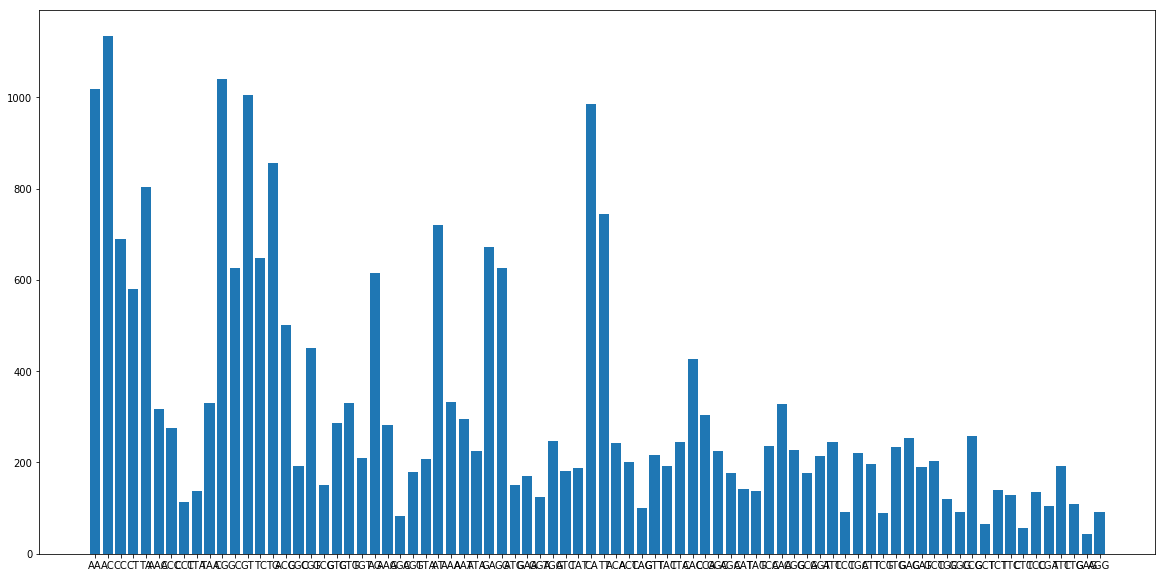

In [14]:
plt.figure(figsize=(20,10))
plt.bar(range(len(ATCG_count_dict)), list(ATCG_count_dict.values()), align='center')
plt.xticks(range(len(ATCG_count_dict)), list(ATCG_count_dict.keys()))
plt.show()